In [42]:
import os
import gzip
import shutil
import sys
import struct
from typing import List

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [43]:
def read_images_archive(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n * rows * columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_labels_archive(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

In [44]:
# Define file paths
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'
test_images_path = 't10k-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'

# Check if files exist in the project folder
if os.path.exists(train_images_path) and os.path.exists(train_labels_path) and \
    os.path.exists(test_images_path) and os.path.exists(test_labels_path):
    print("All files are present in the project folder.")
else:
    print("Some files are missing in the project folder.")

with gzip.open(train_images_path, "rb") as fp:
    train_images = read_images_archive(fp)
    print(f"Loaded training images with shape {train_images.shape}!")

with gzip.open(train_labels_path, "rb") as fp:
    train_labels = read_labels_archive(fp)
    print(f"Loaded training labels with shape {train_labels.shape}!")

with gzip.open(test_images_path, "rb") as fp:
    test_images = read_images_archive(fp)
    print(f"Loaded test images with shape {test_images.shape}!")

with gzip.open(test_labels_path, "rb") as fp:
    test_labels = read_labels_archive(fp)
    print(f"Loaded test labels with shape {test_labels.shape}!")

All files are present in the project folder.
Loaded training images with shape (60000, 28, 28)!
Loaded training labels with shape (60000,)!
Loaded test images with shape (10000, 28, 28)!
Loaded test labels with shape (10000,)!


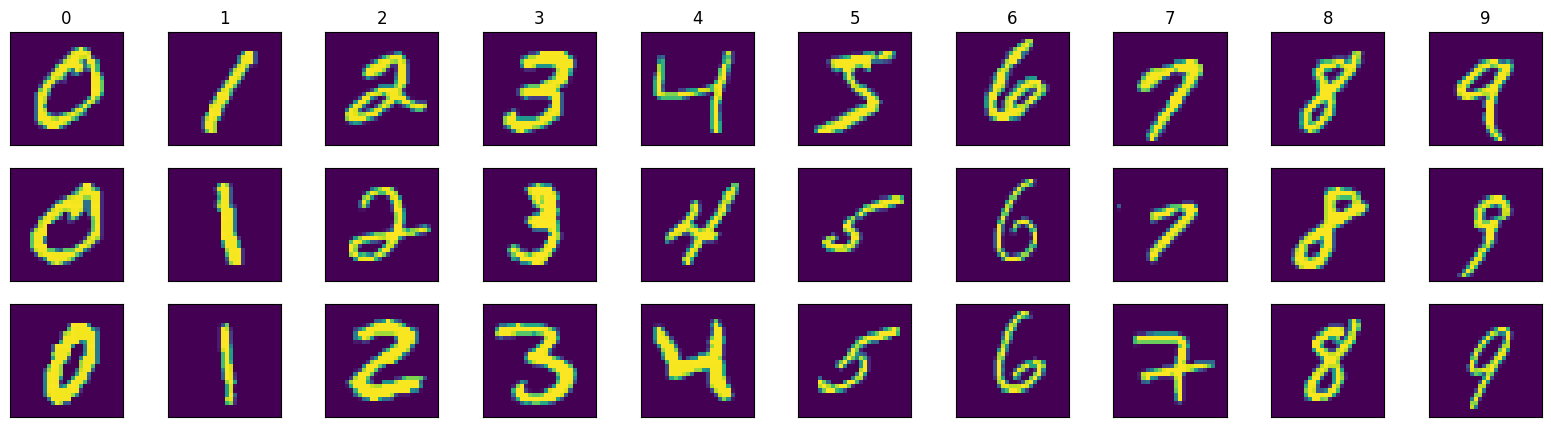

In [45]:
# NOTE: visualize training dataset
_nrows = 3
fig, axes = plt.subplots(nrows=_nrows, ncols=10, figsize=(20, 5))
for lbl in range(10):
    for r in range(_nrows):
        ax = axes[r][lbl]
        ax.imshow(train_images[train_labels == lbl][r])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f"{lbl}")

In [46]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, model_type="mlp"):
        """
        Universal MNIST dataset class supporting MLP, CNN, and RNN models.

        Parameters:
        - images: numpy array of shape (num_samples, 28, 28), pixel values in range [0, 255]
        - labels: numpy array of shape (num_samples,), integer labels for each image
        - model_type:
            - 'mlp'  -> Fully connected network (vector input)
            - 'cnn'  -> Convolutional network (image format with 1 channel)
            - 'rnn'  -> Recurrent network (sequence of 28 rows)
        """

        if len(images) != len(labels):
            raise ValueError(f"Different number of images ({len(images)}) and labels ({len(labels)})!")

        # Normalize images to [0,1] and store labels
        self.images = (images / 255.0).astype(np.float32)
        self.labels = labels
        self.model_type = model_type.lower()

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, index):
        """Retrieves an image and its corresponding label at the given index."""
        image = self.images[index]

        if self.model_type == "mlp":
            image = image.flatten()  # Convert 28x28 to a 1D vector [784]
        elif self.model_type == "cnn":
            image = image[None, ...]  # Add a channel dimension [1, 28, 28]
        elif self.model_type == "rnn":
            image = image  # Keep as a sequence of 28 rows [28, 28]

        # Convert to PyTorch tensors
        image = torch.from_numpy(image)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label

In [47]:
class UniversalNN(nn.Module):
    def __init__(self, model_type: str, input_shape, hidden_units: List[int], num_classes: int):
        """
        Universal Neural Network that supports MLP, CNN, and RNN.

        Parameters:
        - model_type: "mlp", "cnn", or "rnn"
        - input_shape: Tuple representing input dimensions (e.g., (1, 28, 28) for CNN)
        - hidden_units: List of hidden layer sizes (e.g., [128, 64] for MLP)
        - num_classes: Number of output classes (e.g., 10 for MNIST)
        """
        super().__init__()
        self.model_type = model_type.lower()

        if self.model_type == "mlp":
            # Flatten the input from (28, 28) to a vector (784)
            nin = input_shape[0] * input_shape[1] * input_shape[2]
            sizes = [nin] + hidden_units + [num_classes]
            self.layers = nn.ModuleList([nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)])

        elif self.model_type == "cnn":
           # Convolutional Neural Network (CNN)
            self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.dropout = nn.Dropout(0.25)

            # Calculate the size after convolutions (Assuming 28x28 input)
            fc_input_size = 64 * (input_shape[1] // 2) * (input_shape[2] // 2)

            self.fc1 = nn.Linear(fc_input_size, hidden_units[0])
            self.fc2 = nn.Linear(hidden_units[0], num_classes)

        elif self.model_type == "rnn":
            # Define a simple RNN with one recurrent layer
            self.rnn = nn.LSTM(input_size=28, hidden_size=hidden_units[0], batch_first=True)
            self.fc = nn.Linear(hidden_units[0], num_classes)

    def forward(self, x):
        if self.model_type == "mlp":
            x = x.view(x.size(0), -1)  # Flatten for MLP
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))  # ReLU for hidden layers
            x = self.layers[-1](x)  # Last layer (no activation)

        elif self.model_type == "cnn":
            x = F.relu(self.conv1(x))
            x = self.pool(F.relu(self.conv2(x)))  # ReLU after conv2
            x = self.dropout(x)
            x = x.view(x.size(0), -1)  # Flatten for FC layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

        elif self.model_type == "rnn":
            x, _ = self.rnn(x)  # LSTM forward
            x = x[:, -1, :]  # Take the last output in sequence
            x = self.fc(x)

        return x

def init_parameters(model):
    if type(model) == nn.Linear:
        nn.init.xavier_uniform_(model.weight)
        model.bias.data.fill_(0.01)
    elif type(model) == nn.LSTM:
        for name, param in model.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                param.data.fill_(0.01)
    elif type(model) == nn.Conv2d:
        nn.init.xavier_uniform_(model.weight)

In [48]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
    model_type: str = "mlp"
) -> dict:
    """
    Trains the given model for one epoch.

    Parameters:
    - model: The neural network model (MLP, CNN, or RNN).
    - loader: DataLoader for training data.
    - criterion: Loss function (e.g., CrossEntropyLoss).
    - optimizer: Optimizer (e.g., Adam, SGD).
    - device: "cpu" or "cuda" (GPU).
    - verbose: Whether to show training progress.
    - model_type: Type of model ("mlp", "cnn", or "rnn").

    Returns:
    - Dictionary containing training losses and accuracies.
    """

    # Set the model to training mode
    model.train()

    # Track losses and accuracies
    losses = []
    accuracies = []

    # Progress bar
    with tqdm(total=len(loader), desc="Training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            # Move data to device (CPU/GPU)
            x_batch, y_true = x_batch.to(device), y_true.to(device)

            # Ensure y_true has shape (B,)
            if y_true.ndimension() > 1:
                y_true = y_true.squeeze(1)

            if model_type == "mlp":
                x_batch = x_batch.view(x_batch.size(0), -1)  # Flatten input for MLP
            elif model_type == "cnn":
                x_batch = x_batch.view(x_batch.size(0), 1, 28, 28)  # Reshape for CNN (B, 1, 28, 28)
            elif model_type == "rnn":
                x_batch = x_batch.view(x_batch.size(0), 28, 28)  # Reshape for RNN (B, 28, 28)

            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(x_batch)

            # Compute loss
            loss = criterion(y_pred, y_true)

            # Backward pass (compute gradients)
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Store loss and accuracy
            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            # Update progress bar
            progress.set_postfix_str(f"loss {losses[-1]:.4f}")
            progress.update(1)

    # Aggregate training logs
    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs

In [49]:
@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
    model_type: str = "mlp"
) -> dict:
    # Set the model to evaluation mode
    model.eval()

    # Lists to store losses and accuracies during evaluation
    losses = []
    accuracies = []

    # tqdm provides a progress bar during evaluation
    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        # Move the input and target tensors to the specified device (CPU or GPU)
        x_batch, y_true = x_batch.to(device), y_true.to(device)

        # Ensure y_true has shape (B,)
        if y_true.ndimension() > 1:
            y_true = y_true.squeeze(1)

        # Reshape input based on model type
        if model_type == "mlp":
            x_batch = x_batch.view(x_batch.size(0), -1)  # Flatten input for MLP
        elif model_type == "cnn":
            x_batch = x_batch.view(x_batch.size(0), 1, 28, 28)  # Reshape for CNN (B, 1, 28, 28)
        elif model_type == "rnn":
            x_batch = x_batch.view(x_batch.size(0), 28, 28)  # Reshape for RNN (B, 28, 28)

        # Obtain model predictions
        y_pred = model(x_batch)

        # Compute the loss using the specified criterion
        loss = criterion(y_pred, y_true)

        # Append the loss and accuracy for logging purposes
        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    # Aggregate and return evaluation logs
    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs


In [50]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

Device - cpu


In [51]:
# NOTE: you can change batch size to increase the model convergence
batch_size = 50

# Create training data loader
train_loader = DataLoader(
    MNISTDataset(train_images, train_labels),  # MNIST training dataset
    batch_size=batch_size,  # Set batch size
    shuffle=True,  # Shuffle the data during training
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=True,  # Drop the last incomplete batch if its size is less than batch_size
)

# Create validation data loader
valid_loader = DataLoader(
    MNISTDataset(test_images, test_labels),  # MNIST test dataset for validation
    batch_size=batch_size,  # Set batch size
    shuffle=False,  # Do not shuffle the data during validation
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=False,  # Keep the last batch even if its size is less than batch_size
)

# MLP with SGD optimizer
n_epochs = 50
# Create a Multilayer Perceptron (MLP) model with specified architecture
model = UniversalNN(model_type="mlp", input_shape=(1, 28, 28), hidden_units=[400], num_classes=10)

# NOTE: move model to device to speed up training using GPU parallelization
model = model.to(device)

# NOTE: to handle model randomnes - set a random seed to ensure reproducibility before initializing model parameters
torch.manual_seed(42)

# Initialize the parameters of the model
model.apply(init_parameters)

# Print the number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# NOTE: you can play with learning rate to increase convergence
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=.9)

# Define the loss function (Cross Entropy Loss) for training the model
loss_fn = nn.CrossEntropyLoss()
# Lists to store training and validation losses and accuracies for each epoch
train_losses = []
train_accuracies = []

valid_losses = []
valid_accuracies = []

# Loop over epochs for training
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training logs
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True, model_type="mlp")
    train_losses.append(np.mean(train_logs["losses"]))
    train_accuracies.append(np.mean(train_logs["accuracies"]))
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect validation logs
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True, model_type="mlp")
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))
    print("      loss:", valid_losses[-1])
    print("  accuracy:", valid_accuracies[-1])

Number of trainable parameters - 318010

Epoch  1/50
Training: 100%|████████████████████████████████████| 1200/1200 [00:17<00:00, 68.22it/s, loss 2.2931]
      loss: 2.2993726523717246
  accuracy: 0.11818333
evaluation: 100%|████████████████████████████████████████████████| 200/200 [00:01<00:00, 173.81it/s]
      loss: 2.2961886310577393
  accuracy: 0.1135

Epoch  2/50
Training: 100%|████████████████████████████████████| 1200/1200 [00:19<00:00, 60.28it/s, loss 2.2990]
      loss: 2.294470206697782
  accuracy: 0.12778333
evaluation: 100%|████████████████████████████████████████████████| 200/200 [00:01<00:00, 159.96it/s]
      loss: 2.291116679906845
  accuracy: 0.1028

Epoch  3/50
Training: 100%|████████████████████████████████████| 1200/1200 [00:20<00:00, 59.87it/s, loss 2.2823]
      loss: 2.288614342013995
  accuracy: 0.13921666
evaluation: 100%|████████████████████████████████████████████████| 200/200 [00:01<00:00, 171.56it/s]
      loss: 2.285665196180344
  accuracy: 0.1147

Epoch 

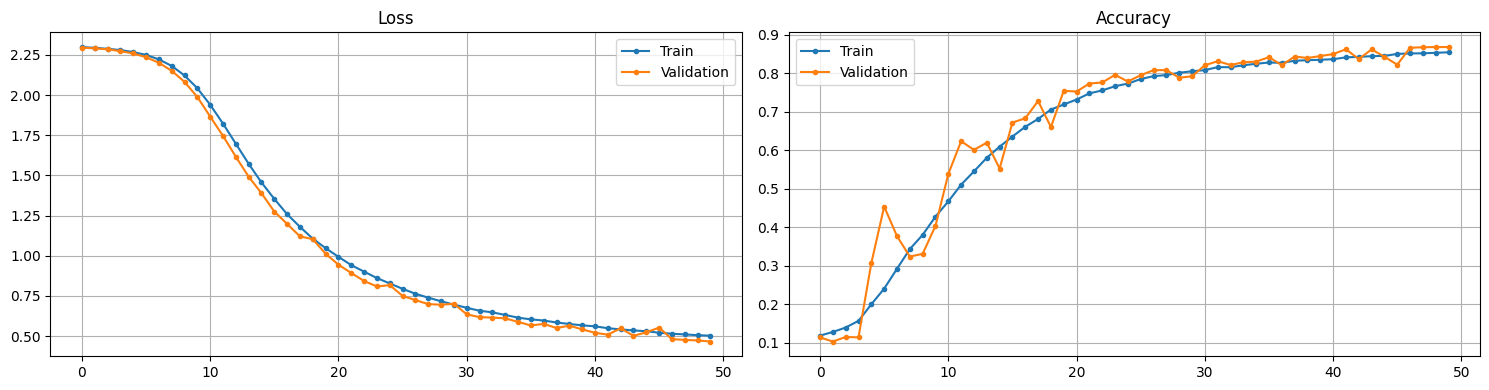

In [52]:
# Create subplots for loss and accuracy comparison for MLP with SGD opt

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot training and validation losses
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["Train", "Validation"])
axes[0].set_title("Loss")  # Set title for the loss subplot
axes[0].grid()  # Add grid lines to the plot

# Plot training and validation accuracies
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
axes[1].legend(["Train", "Validation"])
axes[1].set_title("Accuracy")  # Set title for the accuracy subplot
axes[1].grid()  # Add grid lines to the plot

# Show the plots
fig.tight_layout()
plt.show()

In [53]:
# NOTE: you can change batch size to increase the model convergence
batch_size = 50

# Create training data loader
train_loader = DataLoader(
    MNISTDataset(train_images, train_labels),  # MNIST training dataset
    batch_size=batch_size,  # Set batch size
    shuffle=True,  # Shuffle the data during training
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=True,  # Drop the last incomplete batch if its size is less than batch_size
)

# Create validation data loader
valid_loader = DataLoader(
    MNISTDataset(test_images, test_labels),  # MNIST test dataset for validation
    batch_size=batch_size,  # Set batch size
    shuffle=False,  # Do not shuffle the data during validation
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=False,  # Keep the last batch even if its size is less than batch_size
)

# MLP with Adam optimizer
n_epochs = 40
# Create a Multilayer Perceptron (MLP) model with specified architecture
model = UniversalNN(model_type="mlp", input_shape=(1, 28, 28), hidden_units=[400], num_classes=10)

# NOTE: move model to device to speed up training using GPU parallelization
model = model.to(device)

# NOTE: to handle model randomnes - set a random seed to ensure reproducibility before initializing model parameters
torch.manual_seed(42)

# Initialize the parameters of the model
model.apply(init_parameters)

# Print the number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# NOTE: use this optimizer to see the difference in optimization compared with SGD
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function (Cross Entropy Loss) for training the model
loss_fn = nn.CrossEntropyLoss()
# Lists to store training and validation losses and accuracies for each epoch
train_losses = []
train_accuracies = []

valid_losses = []
valid_accuracies = []

# Loop over epochs for training
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training logs
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True, model_type="mlp")
    train_losses.append(np.mean(train_logs["losses"]))
    train_accuracies.append(np.mean(train_logs["accuracies"]))
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect validation logs
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True, model_type="mlp")
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))
    print("      loss:", valid_losses[-1])
    print("  accuracy:", valid_accuracies[-1])

Number of trainable parameters - 318010

Epoch  1/40
Training: 100%|████████████████████████████████████| 1200/1200 [00:20<00:00, 58.52it/s, loss 0.5871]
      loss: 0.9302260495722294
  accuracy: 0.7762333
evaluation: 100%|████████████████████████████████████████████████| 200/200 [00:01<00:00, 181.81it/s]
      loss: 0.42662884838879106
  accuracy: 0.8913

Epoch  2/40
Training: 100%|████████████████████████████████████| 1200/1200 [00:21<00:00, 54.62it/s, loss 0.2501]
      loss: 0.3792408939637244
  accuracy: 0.89571667
evaluation: 100%|████████████████████████████████████████████████| 200/200 [00:01<00:00, 192.28it/s]
      loss: 0.3269617838598788
  accuracy: 0.9079

Epoch  3/40
Training: 100%|████████████████████████████████████| 1200/1200 [00:21<00:00, 54.86it/s, loss 0.4325]
      loss: 0.3195021468711396
  accuracy: 0.90833336
evaluation: 100%|█████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.21it/s]
      loss: 0.29293783702887594
  accuracy: 0.915

Ep

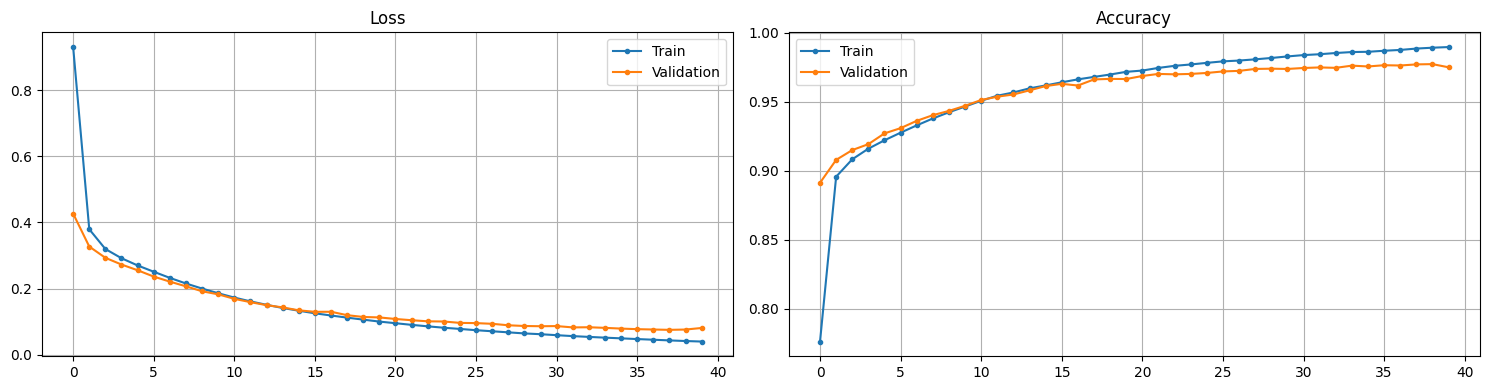

In [54]:
# Create subplots for loss and accuracy comparison for MLP with Adam opt
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot training and validation losses
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["Train", "Validation"])
axes[0].set_title("Loss")  # Set title for the loss subplot
axes[0].grid()  # Add grid lines to the plot

# Plot training and validation accuracies
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
axes[1].legend(["Train", "Validation"])
axes[1].set_title("Accuracy")  # Set title for the accuracy subplot
axes[1].grid()  # Add grid lines to the plot

# Show the plots
fig.tight_layout()
plt.show()

In [59]:
# CNN with Adam optimizer
batch_size = 100

# Create training data loader
train_loader = DataLoader(
    MNISTDataset(train_images, train_labels),  # MNIST training dataset
    batch_size=batch_size,  # Set batch size
    shuffle=True,  # Shuffle the data during training
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=True,  # Drop the last incomplete batch if its size is less than batch_size
)

# Create validation data loader
valid_loader = DataLoader(
    MNISTDataset(test_images, test_labels),  # MNIST test dataset for validation
    batch_size=batch_size,  # Set batch size
    shuffle=False,  # Do not shuffle the data during validation
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=False,  # Keep the last batch even if its size is less than batch_size
)

n_epochs = 10

# Create a Convolutional Neural Network (CNN) model with specified architecture
model = UniversalNN(model_type="cnn", input_shape=(1, 28, 28), hidden_units=[400], num_classes=10)

# Move model to device to speed up training using GPU parallelization
model = model.to(device)

# Set a random seed to ensure reproducibility before initializing model parameters
torch.manual_seed(42)

# Initialize the parameters of the model
model.apply(init_parameters)

# Print the number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function (Cross Entropy Loss) for training the model
loss_fn = nn.CrossEntropyLoss()

# Lists to store training and validation losses and accuracies for each epoch
train_losses = []
train_accuracies = []

valid_losses = []
valid_accuracies = []

# Loop over epochs for training
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training logs
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True, model_type="cnn")
    train_losses.append(np.mean(train_logs["losses"]))  # Average training loss
    train_accuracies.append(np.mean(train_logs["accuracies"]))  # Average training accuracy
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect validation logs
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True, model_type="cnn")
    valid_losses.append(np.mean(valid_logs["losses"]))  # Average validation loss
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))  # Average validation accuracy
    print("      loss:", valid_losses[-1])
    print("  accuracy:", valid_accuracies[-1])

Number of trainable parameters - 5040826

Epoch  1/10
Training: 100%|██████████████████████████████████████| 600/600 [04:43<00:00,  2.11it/s, loss 2.3032]
      loss: 2.303079088528951
  accuracy: 0.11105
evaluation: 100%|█████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]
      loss: 2.301319215297699
  accuracy: 0.1135

Epoch  2/10
Training: 100%|██████████████████████████████████████| 600/600 [05:11<00:00,  1.93it/s, loss 2.3024]
      loss: 2.3014595886071523
  accuracy: 0.11236667
evaluation: 100%|█████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s]
      loss: 2.3012304091453553
  accuracy: 0.1135

Epoch  3/10
Training: 100%|██████████████████████████████████████| 600/600 [05:08<00:00,  1.94it/s, loss 2.2903]
      loss: 2.3014325686295827
  accuracy: 0.11236667
evaluation: 100%|█████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]
      loss: 2.301227984428406
  accuracy: 0.1135

Epoch  

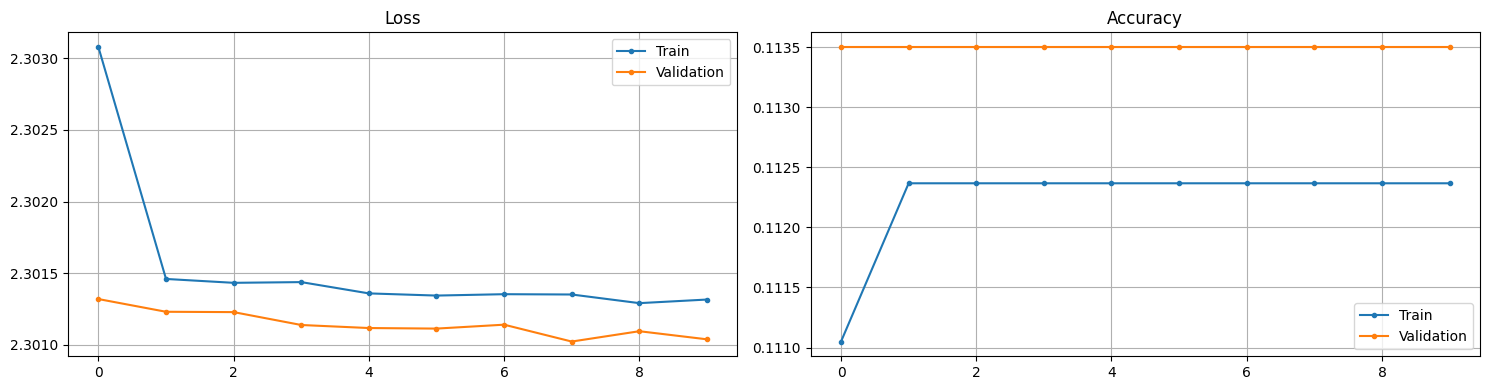

In [60]:
# Create subplots for loss and accuracy comparison for CNN with Adam opt
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot training and validation losses
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["Train", "Validation"])
axes[0].set_title("Loss")  # Set title for the loss subplot
axes[0].grid()  # Add grid lines to the plot

# Plot training and validation accuracies
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
axes[1].legend(["Train", "Validation"])
axes[1].set_title("Accuracy")  # Set title for the accuracy subplot
axes[1].grid()  # Add grid lines to the plot

# Show the plots
fig.tight_layout()
plt.show()

In [62]:
# RNN with Adam optimizer
batch_size = 50

# Create training data loader
train_loader = DataLoader(
    MNISTDataset(train_images, train_labels),  # MNIST training dataset
    batch_size=batch_size,  # Set batch size
    shuffle=True,  # Shuffle the data during training
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=True,  # Drop the last incomplete batch if its size is less than batch_size
)

# Create validation data loader
valid_loader = DataLoader(
    MNISTDataset(test_images, test_labels),  # MNIST test dataset for validation
    batch_size=batch_size,  # Set batch size
    shuffle=False,  # Do not shuffle the data during validation
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=False,  # Keep the last batch even if its size is less than batch_size
)

n_epochs = 10

# Create a Convolutional Neural Network (CNN) model with specified architecture
model = UniversalNN(model_type="rnn", input_shape=(1, 28, 28), hidden_units=[400], num_classes=10)

# Move model to device to speed up training using GPU parallelization
model = model.to(device)

# Set a random seed to ensure reproducibility before initializing model parameters
torch.manual_seed(42)

# Initialize the parameters of the model
model.apply(init_parameters)

# Print the number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function (Cross Entropy Loss) for training the model
loss_fn = nn.CrossEntropyLoss()

# Lists to store training and validation losses and accuracies for each epoch
train_losses = []
train_accuracies = []

valid_losses = []
valid_accuracies = []

# Loop over epochs for training
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training logs
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True, model_type="rnn")
    train_losses.append(np.mean(train_logs["losses"]))  # Average training loss
    train_accuracies.append(np.mean(train_logs["accuracies"]))  # Average training accuracy
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect validation logs
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True, model_type="rnn")
    valid_losses.append(np.mean(valid_logs["losses"]))  # Average validation loss
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))  # Average validation accuracy
    print("      loss:", valid_losses[-1])
    print("  accuracy:", valid_accuracies[-1])

Number of trainable parameters - 692010

Epoch  1/10
Training: 100%|████████████████████████████████████| 1200/1200 [04:00<00:00,  4.99it/s, loss 1.7131]
      loss: 2.252321487367153
  accuracy: 0.14253333
evaluation: 100%|█████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.69it/s]
      loss: 1.6862201076745986
  accuracy: 0.3998

Epoch  2/10
Training: 100%|████████████████████████████████████| 1200/1200 [04:02<00:00,  4.96it/s, loss 0.2699]
      loss: 0.862828251607716
  accuracy: 0.7061
evaluation: 100%|█████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.49it/s]
      loss: 0.5441866118833423
  accuracy: 0.8231

Epoch  3/10
Training: 100%|████████████████████████████████████| 1200/1200 [04:00<00:00,  4.98it/s, loss 0.4423]
      loss: 0.41274603934337695
  accuracy: 0.86611664
evaluation: 100%|█████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.29it/s]
      loss: 0.39510953897610307
  accuracy: 0.8725

Epoch 

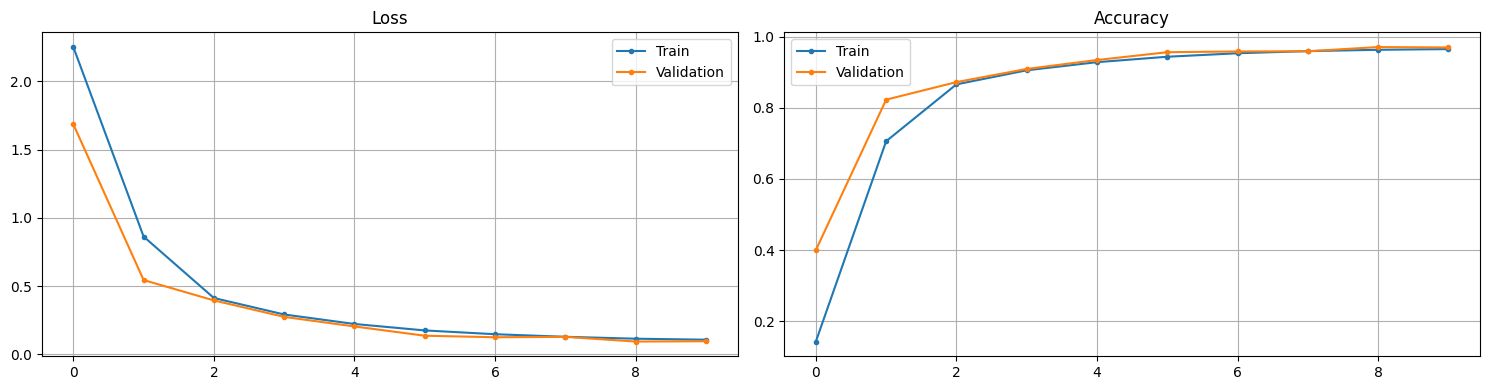

In [63]:
# Create subplots for loss and accuracy comparison for RNN with Adam opt
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot training and validation losses
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["Train", "Validation"])
axes[0].set_title("Loss")  # Set title for the loss subplot
axes[0].grid()  # Add grid lines to the plot

# Plot training and validation accuracies
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
axes[1].legend(["Train", "Validation"])
axes[1].set_title("Accuracy")  # Set title for the accuracy subplot
axes[1].grid()  # Add grid lines to the plot

# Show the plots
fig.tight_layout()
plt.show()

**TODO:**


Write here about model architectures you've tried, it's metrics, and intuition why something worked and something don't.

**1. MLP with SGD Optimizer**

Epochs: 50

Final Training Loss: 0.5029

Final Training Accuracy: 85.46%

Final Validation Loss: 0.4665

Final Validation Accuracy: 86.82%

**2. MLP with Adam Optimizer**

Epochs: 40

Final Training Loss: 0.0397

Final Training Accuracy: 98.97%

Final Validation Loss: 0.0807

Final Validation Accuracy: 97.50%

**3. CNN with Adam Optimizer**

Epochs: 10

Final Training Loss: 2.3013

Final Training Accuracy: 11.24%

Final Validation Loss: 2.3010

Final Validation Accuracy: 11.35%

**4. RNN with Adam Optimizer**

Epochs: 10

Final Training Loss: 0.1072

Final Training Accuracy: 96.53%

Final Validation Loss: 0.0959

Final Validation Accuracy: 97.00%

**Insights and Intuition**

**Optimizer Choice:**

The Adam optimizer generally outperformed SGD in terms of both training and validation accuracy for the MLP and RNN models. Adam's adaptive learning rate helps it converge faster and more effectively.

**Model Complexity:**

The RNN model achieved high accuracy, indicating its effectiveness in handling sequential data, even though MNIST is not inherently sequential. The CNN, however, struggled, which might be due to issues in the architecture or training process.

**Training Duration:**

The RNN model required fewer epochs to reach high accuracy, showing its efficiency in learning from the data.

**Overfitting:**

The MLP with Adam optimizer showed a significant improvement in training accuracy, but the validation accuracy was slightly lower, suggesting potential overfitting. Regularization techniques like dropout or weight decay could help mitigate this.

**Suggestions for Further Improvement**

**Data Augmentation:**

Applying data augmentation techniques (e.g., rotations, translations) can help improve model generalization by providing more varied training examples.

**Hyperparameter Tuning:**

Experimenting with different learning rates, batch sizes, and network architectures (e.g., deeper CNNs) can further optimize performance.

**Advanced Architectures:**

Exploring more advanced architectures like ResNet or using transfer learning with pre-trained models could yield even better results.

**Learning Rate:**

The learning rate might be too high or too low. Try experimenting with different learning rates to find the optimal one.

**Batch Size:**

Adjusting the batch size can sometimes help with convergence. Smaller batch sizes can provide more frequent updates, while larger batch sizes can provide more stable updates.

**Network Architecture:**

The current CNN architecture might be too simple. Consider adding more convolutional layers or using different kernel sizes. You could also try more advanced architectures like VGG or ResNet.

**Initialization:**

Ensure that the weights are initialized properly. Sometimes, poor initialization can lead to suboptimal training.

**Data Preprocessing:**

Double-check the data preprocessing steps. Ensure that the input images are normalized correctly.

**Regularization:**

While dropout is a good start, also other regularization techniques like weight decay (L2 regularization) can be implemented.